## Tasks

1. Price a discretely monitored down-and-out put option in Black-Scholes model.
2. Price a discretely monitored down-and-in call option under the Heston model (Glasserman, P. (2003). Monte carlo methods in financial engineering. Chapter 6, p. 356). 
$\newline$ For discretisation, use formulas at p. 356—357.

## Import libraries

In [14]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(legacy='1.25')

## Barrier Options


info available: 
- https://en.wikipedia.org/wiki/Barrier_option 
- https://www.investopedia.com/terms/b/barrieroption.asp

## 1. Down-and-out put option using the Black-Scholes model

### Geometric Brownian motion

Stochastic Differential Equation (SDE):
$$
dS_t = \mu S_tdt+\sigma S_tdW_t
$$
Explicit Expression
$$
S_t = S_0 e^{(\mu -\frac{\sigma^2}{2})t+\sigma W_t}
$$
Simulation:
$$
S(t_{i+1}) = S(t_i) \exp [ (\mu -\frac{\sigma^2}{2})(t_{i+1}-t_i)+\sigma\sqrt{t_{i+1}-t_i}Z_{i+1} ]
$$


Note: we will use $r$ (risk-free rate) instead of $\mu$ since Black-Scholes model assumes constant volatility and risk-free rate for the duration of the contract


### Parameters

In [15]:
# Parameters for down-and-out put in Black-Scholes 
S0 = 100       # Initial stock price
K = 100        # Strike price
B = 80         # Barrier
T = 1          # Time to maturity
r = 0.05       # Risk-free rate
sigma = 0.3    # Volatility
n = 100        # Number of monitoring points
simulations = 10000  # Number of simulations
dt = T / n      # time step size

### Simulate asset paths

1. Generate the matrix of all Brownian motion increments $\sqrt{\Delta t}Z, \hspace{0.2cm}\text{where}\hspace{0.1cm}Z\sim N(0, 1)$
2. Take the cumulative product of the exponential increments under GBM: $\exp[(r - \frac{\sigma^2}{2}) dt + \sigma \Delta W(t)]$
3. Multiply by S(0) to obtain the entire price series

Note: also works to take the cumulative sum of the logarithmic increments then exp

In [16]:
dW = np.sqrt(dt) * np.random.normal(0, 1, (simulations, n))   
S = S0 * np.cumprod(np.exp((r - 0.5 * sigma**2) * dt + sigma * dW),axis=1)  # axis=1 = rows
S = np.c_[np.ones(simulations) * S0, S] 

### Check for barrier breach and calculate payoffs, the option price is the discoutned mean of the payoffs

In [17]:
payoff = np.zeros(simulations)  
for i in range(simulations):    
    if np.all(S[i, :] > B): # if all values of the series are above the barrier level
        payoff[i] = max(K - S[i, -1], 0) # put payoff
    else:                                  
        payoff[i] = 0
# standard deviation
std_payoff = np.std(payoff)
# Calculate option price
option_price = np.exp(-r * T) * np.mean(payoff) # option price = discounted mean option payoff
# Confidence interval calculation
z_score = 1.96 
cm = z_score * (std_payoff / np.sqrt(simulations)) # confidence margin
ci = (option_price - cm, option_price + cm) # confidence interval
print(f"Estimated price of the down-and-out put option: {option_price}")
print(f"95% Confidence Interval: {ci}")

Estimated price of the down-and-out put option: 0.938763549969817
95% Confidence Interval: (0.8767997552609703, 1.0007273446786638)


### Plot the simulation paths

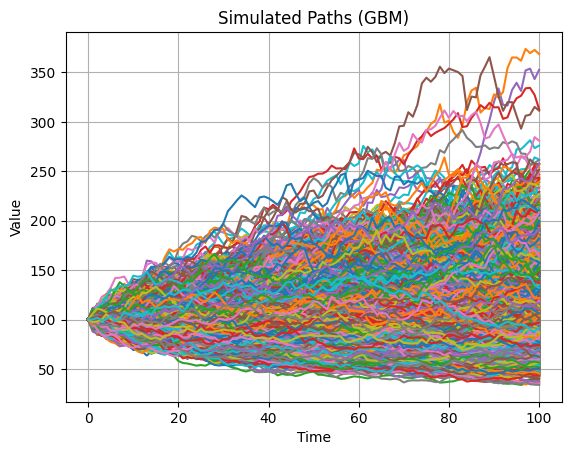

In [18]:
# Plot stock paths
for simulation in S:  # Add every simulation to the plot
    plt.plot(simulation)       
plt.title('Simulated Paths (GBM)')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

## 2. Down-and-in call option using the Heston model

### Heston model

Models asset price using stochastic volatility. 

$\textbf{(Calculations are based on: Glasserman, P. (2003). Monte carlo methods in financial engineering. Chapter 6)}$

\begin{align*}
&dS(t) = r S(t)dt + \sqrt{V(t)} S(t) dW_1(t)\\
& dV(t) = \kappa(\theta-V(t))dt + \sqrt{V(t)}(\sigma_1dW_1(t)+\sigma_2dW_2(t))
\end{align*}

Discretization by simplified second-order scheme.

\begin{align*}
\hat S(i+1)&=
 \hat S(i)(1+rh+\sqrt{\hat V(i)}\Delta W_1) + \frac{1}{2}r^2\hat S(i)h^2\\
&+ \left( 
\left[ r+\frac{\sigma_1-\kappa}{4} \right]\hat S(i)\sqrt{\hat V(i)} 
+ \left[ \frac{\kappa\theta}{4}-\frac{\sigma^2}{16} \right]\frac{\hat S(i)}{\sqrt{\hat V(i)}}\right)
\Delta W_1h \\
&+ \frac{1}{2}\hat S(i)(\hat V(i)+\frac{\sigma_1}{2})(\Delta W_1^2-h)
+\frac{1}{4}\sigma_2\hat S(i) (\Delta W_2 \Delta W_1 + \xi)
\end{align*}

\begin{align*}
\hat V&(i+1) =\\ 
&\kappa\theta h
+ (1-\kappa h)\hat V(i) + \sqrt{\hat V(i)}(\sigma_1 \Delta W_1+\sigma_2 \Delta W_2)
- \frac{1}{2} \kappa^2 (\theta-\hat V(i)) h^2\\
&+ \left(\left[\frac{\kappa\theta}{4} - \frac{\sigma^2}{16}\right] \frac{1}{\sqrt{\hat V(i)}} - \frac{3\kappa}{2}\sqrt{\hat V(i)}
\right)
(\sigma_1 \Delta W_1 + \sigma_2 \Delta W_2) h\\
&+ \frac{1}{4} \sigma_1^2 (\Delta W_1^2 - h)
+ \frac{1}{4} \sigma_2^2 (\Delta W_2^2 - h)
+ \frac{1}{2} \sigma_1 \sigma_2 \Delta W_1 \Delta W_2
\end{align*}

where:
* $\kappa$ is the rate of reversion to the mean variance,
* $\theta$ is the long-term mean variance,
* the brownian motions $W_1$ and $W_2$ are independent of each other.
* $\sigma^2 = \sigma_1^2 + \sigma_2^2$
* $\xi = \{-h, h\}$ with probability 1/2
* $h$ is the time step size ($dt$)

### Parameters

In [19]:
K = 100        # Strike price
B = 90         # Barrier
T = 1          # Time to maturity
r = 0.05       # Risk-free rate
sigma = 0.3    # Volatility
n = 100        # Number of monitoring points 
simulations = 10000  # Number of simulations
h = T/n        # time step size (dt)
rho = -0.5     # Correlation of the two Brownian motions
kappa = 1.2    # Mean reversion coefficient
theta = 0.04   # Long-term mean variance
sigma1 = rho*sigma 
sigma2 = np.sqrt(sigma**2 - sigma1**2)
S = np.zeros((simulations, n))  # Asset price initialization
V = np.zeros((simulations, n))  # Volatility initialization
S[:, 0] = 100   # First column = initial value for underlying asset
V[:, 0] = 0.04  # First column = initial value for volatility

### Brownian motion deltas and $\xi$ matrix generation

In [20]:
dW1 = np.random.normal(0, np.sqrt(h), (simulations, n))
dW2 = np.random.normal(0, np.sqrt(h), (simulations, n))
xi = np.random.choice([h, -h], size=(simulations, n), p=[0.5, 0.5])

### Stochastic volatility calculation

In [21]:
for i in range(n-1):
    V[:, i+1] = (
                kappa*theta*h
                + (1-kappa*h)*V[:, i]
                + np.sqrt(V[:, i])*(sigma1*dW1[:, i]+sigma2*dW2[:, i])
                - (0.5*(kappa**2) * (theta-V[:, i]) * (h**2))
                + ((((kappa*theta)/4 - (sigma**2)/16)* (1/np.sqrt(V[:, i])) - ((3*kappa)/2)*np.sqrt(V[:, i]))
                * (sigma1*dW1[:, i] + sigma2*dW2[:, i]) * h)
                + ((1/4)*(sigma1**2) * (dW1[:, i]**2 - h)) + ((1/4)*(sigma2**2)*(dW2[:, i]**2 - h))
                + ((1/2)*sigma1*sigma2*dW1[:, i]*dW2[:, i])
                )

### Asset price calculation

In [22]:
for i in range(n-1):
    S[:, i+1] = (
                S[:, i]*(1 + r*h + np.sqrt(V[:, i]) * dW1[:, i]) 
                + 0.5*(r**2)*S[:, i]*(h**2) 
                + ((r+((sigma1-kappa)/4))*S[:, i]*np.sqrt(V[:, i]) + ((kappa*theta)/4 - (sigma**2)/16)*(S[:, i]/np.sqrt(V[:, i])))*dW1[:, i]*h
                + 0.5 * S[:, i] * (V[:, i]+ sigma1/2)*(dW1[:, i]**2 - h) 
                + (1/4)*sigma2 * S[:, i] * (dW2[:, i]*dW1[:, i]+xi[:, i])
                )

### Check for barrier breach and calculate payoff and option price

In [23]:
payoff = np.zeros(simulations)  
for i in range(simulations):    # for each simulation
    if np.any(S[i, :] < B):     # if any value in the series was below the barrier level
            payoff[i] = max(S[i, -1] - K, 0) # call payoff
    else:                                 
        payoff[i] = 0 
# standard deviation
std_payoff = np.std(payoff)
# Calculate option price
option_price = np.exp(-r * T) * np.mean(payoff) # option price = discounted mean option payoff
# Confidence interval calculation
z_score = 1.96 
cm = z_score * (std_payoff / np.sqrt(simulations)) # confidence margin
ci = (option_price - cm, option_price + cm) # confidence interval
print(f"Estimated price of the down-and-in call option: {option_price}")
print(f"95% Confidence Interval: {ci}")

Estimated price of the down-and-in call option: 1.5918104213979976
95% Confidence Interval: (1.4782517269396698, 1.7053691158563253)


### Plot the simulated paths

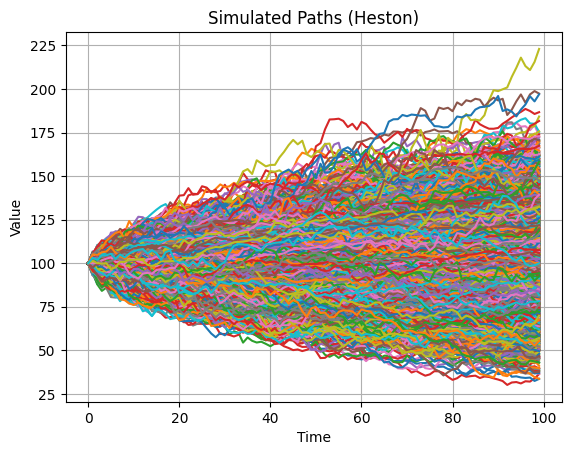

In [24]:
# Plot stock paths
for simulation in S:  # Add every simulation to the plot
    plt.plot(simulation)        
plt.title('Simulated Paths (Heston)')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

### 2. Correctness

Pricing a European call option using the same model and compare to Glasserman p.357

In [25]:
payoff = np.zeros(simulations)  # initialize payoff for each simulation  
# European call option, no barrier
for i in range(simulations): 
    payoff[i] = max(S[i, -1] - K, 0)
# standard deviation
std_payoff = np.std(payoff)
# Calculate option price
option_price = np.exp(-r * T) * np.mean(payoff) # option price = discounted mean option payoff
# Confidence interval calculation
z_score = 1.96
cm =z_score * (std_payoff / np.sqrt(simulations)) # confidence margin
ci = (option_price - cm, option_price + cm) # confidence interval
print(f"Estimated price of the European call option: {option_price}")
print(f"95% Confidence Interval: {ci}")

Estimated price of the European call option: 10.312748526409
95% Confidence Interval: (10.049891706181059, 10.575605346636943)


They evaluate a standard European call option under the Heston model (not this discretized version) to 10.3009, which is in our confidence interval.

Accuracy goes up as time intervals decrease and simulations increase (closer to continuous).

## Extras

In [26]:
# numpy uses (mean, std (not variance!))
np.random.seed(50)
dW1 = np.sqrt(h) * np.random.normal(0, 1, (simulations, n))
print(dW1[0, :10])
np.random.seed(50)
dW1 = np.random.normal(0, np.sqrt(h), (simulations, n))
print(dW1[0, :10])

[-0.15603521 -0.00309776 -0.06209284 -0.14645805  0.14119461 -0.04767321
 -0.07804692  0.10702677 -0.12822926 -0.13274789]
[-0.15603521 -0.00309776 -0.06209284 -0.14645805  0.14119461 -0.04767321
 -0.07804692  0.10702677 -0.12822926 -0.13274789]
